In [5]:
"""
@author Dakota Rawlings
@email dakota@mrl.ucsb.edu

This script performs all of the feature engienering in preparation for training our model

This includes making lag columns, rescaling columns, seasonal indicators, and fourier features etc.

"""

from statsmodels.tsa.deterministic import CalendarFourier
from sklearn.linear_model import LinearRegression
import sqlite3
import pandas as pd
from pandas import date_range

## Importing and formatting data

In [6]:
#Format a dataframe after impoting from SQL
def format_df(df_in):
    """Function for formatting a dataframe from the database file with model training NDBC data
    
    :type df_in: obj (dataframe) -  Dataframe that has been uploaded from NDBC SQL database
    :rtype dataframe - formatted dataframe
    """

    df=df_in.copy(deep=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df=df.set_index('datetime')
    df["date"] = pd.to_datetime(df["date"])
    return df

In [7]:
#Query a list of tables from the model building database
con = sqlite3.connect(r"NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_data_for_training',), ('NDBC_historical_cleaned_data',)]


In [8]:
#Query cleaned data from DB
conn = sqlite3.connect(r"NDBC_model_building_database.db")
df_cleaned = pd.read_sql_query("SELECT * FROM NDBC_historical_cleaned_data", conn, index_col=None)

In [9]:
#Format our queried data using our function defined above
df_engineered=format_df(df_cleaned)

## Basic Feature Engineering and EDA

In [10]:
#For starters we are going to try predicting the max daily air temperature, so we resample all of our data to daily frequency with the max daily value
df_engineered= df_engineered.resample("D").max()

In [11]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    3910 non-null   float64       
 1   WSPD    3910 non-null   float64       
 2   GST     3910 non-null   float64       
 3   PRES    3910 non-null   float64       
 4   ATMP    3910 non-null   float64       
 5   WTMP    3910 non-null   float64       
 6   date    3910 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 244.4 KB


In [12]:
#create fourier features based on the time index of our df
fourier_pairs=CalendarFourier(freq="A", order=3)
X=fourier_pairs.in_sample(df_engineered.index)
#Add a constant to our features for the linear fit
X['constant'] = 1

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sin(1,freq=A-DEC)  3910 non-null   float64
 1   cos(1,freq=A-DEC)  3910 non-null   float64
 2   sin(2,freq=A-DEC)  3910 non-null   float64
 3   cos(2,freq=A-DEC)  3910 non-null   float64
 4   sin(3,freq=A-DEC)  3910 non-null   float64
 5   cos(3,freq=A-DEC)  3910 non-null   float64
 6   constant           3910 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 244.4 KB


## Fourier and Time Step Features

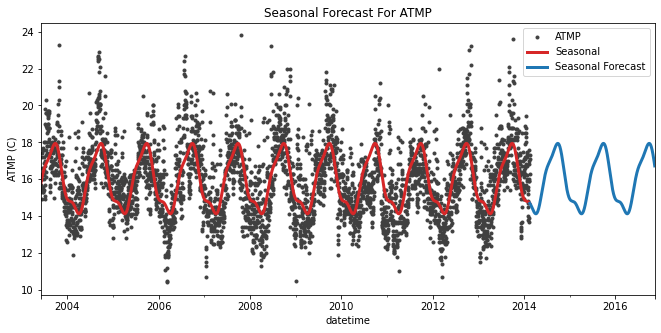

In [16]:
#Fit our target variable to the fourier features using a linear fit
#using Aair temp as our target
y = df_engineered["ATMP"]
#fit a linear model 
model = LinearRegression(fit_intercept=False)
results = model.fit(X, y)
#create an index for our forecast beyond the data
forecast_index = date_range(start=X.index[-1], freq="D", periods=1000)
#Generate data for our fit within our data range
y_pred = pd.Series(model.predict(X), index=y.index)
#generate fourier features for our forecast index (beyond our data)
X_fore = fourier_pairs.out_of_sample(steps=1000, index=X.index, forecast_index=forecast_index)
#add a constant to our forecast features
X_fore['constant']=1
#Generate fit data for our forecast index
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
#Plot our data, our data fit, and our forecast fit
ax = y.plot(color='0.25', style='.', title=f"Seasonal Forecast For {y.name}",ylabel="ATMP (C)" ,figsize=(11, 5))
ax = y_pred.plot(ax=ax, label="Seasonal", linewidth=3, color='C3')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", linewidth=3, color='C0')
leg=ax.legend()

In [ ]:
#df_engineered=df_engineered.join(X)

In [ ]:
def make_lag_columns(df_in, num_lags, lag_column):
    """Function for making lag columns for a particular feature

        :type df_in: dataframe - Dataframe with columns to be lagged
        :type num_lags: int - number of lag columns to make for a particular feature
        :type lag_column: str - feature for which lag columns will be made
        :rtype: dataframe - dataframe with lag columns added to df_in
    """

    #copy dataframe so that it is not modified in place
    df=df_in.copy(deep=True)
    #loop though num_lags
    for i in range(num_lags):
        #Start lags at 1
        lag=i+1
        #Make new column with shifted feature
        new_lag_column=f'{lag_column}_lag_{lag}'
        df[new_lag_column]=df[lag_column].shift(lag)
        #note: we do not drop Nans because we will apply this function on a dataframe multiple times
    return df

In [ ]:
#Make lag features for air temp, water temp, and wind speed
df_engineered=make_lag_columns(df_engineered, 8, 'ATMP')
df_engineered=make_lag_columns(df_engineered, 8, 'WTMP')
df_engineered=make_lag_columns(df_engineered, 2, 'WSPD')
df_engineered.dropna(inplace=True)

In [ ]:
# Add seasonal indicators
df_engineered["Month"] = df_engineered.index.month

In [ ]:
#Save data to local SQLite database
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_engineered.to_sql(name=f'NDBC_historical_data_for_training',con=conn,schema='NDBC_model_building_database.db',if_exists='replace') 


In [ ]:
#Query a list of the tables in our dataframe
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_cleaned_data',), ('NDBC_historical_data_for_training',)]
